#### Convert keypoints to geo-coord (visualization)

In [2]:
import os
import sys
sys.path.append(os.path.abspath('/home/savvas/SUPER-NAS/USERS/Chirag/PROJECTS/202504-spacenet9/data/spacenet9-void/src'))


In [ ]:
import pandas as pd
import json
from shapely.geometry import mapping, Point
from osgeo import gdal, osr
from utils.geo import translate_tiepoints_to_geo_coords, transform_to_epsg

sar_path = "/home/savvas/SUPER-NAS/USERS/Chirag/PROJECTS/202504-spacenet9/data/spacenet9-void/data/train/03_sar_train_01.tif"
opt_path = "/home/savvas/SUPER-NAS/USERS/Chirag/PROJECTS/202504-spacenet9/data/spacenet9-void/data/train/03_optical_train_01.tif"
tiepoints_path = "/home/savvas/SUPER-NAS/USERS/Chirag/PROJECTS/202504-spacenet9/data/spacenet9-void/data/train/03_tiepoints_train_01.csv"
output_geojson_path = "/home/savvas/SUPER-NAS/USERS/Chirag/PROJECTS/202504-spacenet9/data/spacenet9-void/data/train/03_tiepoints_train_01.geojson"

sar_ds = gdal.Open(sar_path)
opt_ds = gdal.Open(opt_path)
sar_gt = sar_ds.GetGeoTransform()
opt_gt = opt_ds.GetGeoTransform()

# === Get EPSG codes ===
sar_srs = osr.SpatialReference(wkt=sar_ds.GetProjection())
opt_srs = osr.SpatialReference(wkt=opt_ds.GetProjection())
sar_epsg = int(sar_srs.GetAttrValue('AUTHORITY', 1))
opt_epsg = int(opt_srs.GetAttrValue('AUTHORITY', 1))

# === Load tiepoints ===
df = pd.read_csv(tiepoints_path)

# === Convert image coords to geo coords ===
sar_y, sar_x = translate_tiepoints_to_geo_coords(df['sar_row'], df['sar_col'], sar_gt)
opt_y, opt_x = translate_tiepoints_to_geo_coords(df['optical_row'], df['optical_col'], opt_gt)

# === Reproject optical points to SAR CRS if needed ===
if opt_epsg != sar_epsg:
    opt_points = [Point(x, y) for x, y in zip(opt_x, opt_y)]
    opt_points_reprojected = transform_to_epsg(opt_points, opt_epsg, sar_epsg)
    opt_x = [p.x for p in opt_points_reprojected]
    opt_y = [p.y for p in opt_points_reprojected]

# === Prepare GeoJSON features ===
features = []
for i in range(len(sar_x)):
    sar_point = Point(sar_x[i], sar_y[i])
    opt_point = Point(opt_x[i], opt_y[i])
    features.append({
        "type": "Feature",
        "geometry": mapping(sar_point),
        "properties": {
            "type": "sar",
            "index": i
        }
    })
    features.append({
        "type": "Feature",
        "geometry": mapping(opt_point),
        "properties": {
            "type": "optical",
            "index": i
        }
    })

# === Create GeoJSON with CRS block ===
geojson = {
    "type": "FeatureCollection",
    "crs": {
        "type": "name",
        "properties": {
            "name": f"EPSG:{sar_epsg}"
        }
    },
    "features": features
}

# === Save to file ===
with open(output_geojson_path, 'w') as f:       
    json.dump(geojson, f, indent=2)



### Save in separate file 

In [13]:
import pandas as pd
import json
from shapely.geometry import mapping, Point
from osgeo import gdal, osr
from utils.geo import translate_tiepoints_to_geo_coords, transform_to_epsg

# === File paths ===
sar_path = "/home/savvas/SUPER-NAS/USERS/Chirag/PROJECTS/202504-spacenet9/data/spacenet9-void/data/train/03_sar_train_01.tif"
opt_path = "/home/savvas/SUPER-NAS/USERS/Chirag/PROJECTS/202504-spacenet9/data/spacenet9-void/data/train/03_optical_train_01.tif"
tiepoints_path = "/home/savvas/SUPER-NAS/USERS/Chirag/PROJECTS/202504-spacenet9/data/spacenet9-void/data/train/03_tiepoints_train_01.csv"
base_output_path = os.path.splitext(tiepoints_path)[0]  # "02_tiepoints_train_01"

# === Load datasets ===
sar_ds = gdal.Open(sar_path)
opt_ds = gdal.Open(opt_path)
sar_gt = sar_ds.GetGeoTransform()
opt_gt = opt_ds.GetGeoTransform()

# === Get EPSG codes ===
sar_srs = osr.SpatialReference(wkt=sar_ds.GetProjection())
opt_srs = osr.SpatialReference(wkt=opt_ds.GetProjection())
sar_epsg = int(sar_srs.GetAttrValue('AUTHORITY', 1))
opt_epsg = int(opt_srs.GetAttrValue('AUTHORITY', 1))

# === Load tiepoints ===
df = pd.read_csv(tiepoints_path)

# === Convert image coords to geo coords ===
sar_y, sar_x = translate_tiepoints_to_geo_coords(df['sar_row'], df['sar_col'], sar_gt)
opt_y, opt_x = translate_tiepoints_to_geo_coords(df['optical_row'], df['optical_col'], opt_gt)

# === Reproject optical points to SAR CRS if needed ===
if opt_epsg != sar_epsg:
    opt_points = [Point(x, y) for x, y in zip(opt_x, opt_y)]
    opt_points_reprojected = transform_to_epsg(opt_points, opt_epsg, sar_epsg)
    opt_x = [p.x for p in opt_points_reprojected]
    opt_y = [p.y for p in opt_points_reprojected]

# === Create separate GeoJSONs ===
def create_geojson(points, typ, epsg, out_path):
    features = []
    for i, pt in enumerate(points):
        features.append({
            "type": "Feature",
            "geometry": mapping(pt),
            "properties": {
                "type": typ,
                "index": i
            }
        })

    geojson = {
        "type": "FeatureCollection",
        "crs": {
            "type": "name",
            "properties": {
                "name": f"EPSG:{epsg}"
            }
        },
        "features": features
    }

    with open(out_path, 'w') as f:
        json.dump(geojson, f, indent=2)
    print(f"{typ.capitalize()} GeoJSON saved to {out_path}")

# === Generate points and save ===
sar_points = [Point(x, y) for x, y in zip(sar_x, sar_y)]
opt_points = [Point(x, y) for x, y in zip(opt_x, opt_y)]

create_geojson(sar_points, "sar", sar_epsg, base_output_path + "_sar.geojson")
create_geojson(opt_points, "optical", sar_epsg, base_output_path + "_optical.geojson")


Sar GeoJSON saved to /home/savvas/SUPER-NAS/USERS/Chirag/PROJECTS/202504-spacenet9/data/spacenet9-void/data/train/03_tiepoints_train_01_sar.geojson
Optical GeoJSON saved to /home/savvas/SUPER-NAS/USERS/Chirag/PROJECTS/202504-spacenet9/data/spacenet9-void/data/train/03_tiepoints_train_01_optical.geojson


### Create distance geo

In [19]:
import geopandas as gpd
from shapely.geometry import LineString
import pandas as pd

# === Input paths ===
optical_path = "/home/savvas/SUPER-NAS/USERS/Chirag/PROJECTS/202504-spacenet9/data/spacenet9-void/data/train/keypoint-crps/03_tiepoints_train_01_optical.geojson"
sar_path = "/home/savvas/SUPER-NAS/USERS/Chirag/PROJECTS/202504-spacenet9/data/spacenet9-void/data/train/keypoint-crps/03_tiepoints_train_01_sar.geojson"
output_path = "/home/savvas/SUPER-NAS/USERS/Chirag/PROJECTS/202504-spacenet9/data/spacenet9-void/data/train/keypoint-crps/03_tiepoints_train_01_distance.geojson"

# === Load GeoJSONs ===
gdf_opt = gpd.read_file(optical_path)
gdf_sar = gpd.read_file(sar_path)

# === Ensure both have index and are sorted the same way ===
gdf_opt = gdf_opt.set_index("index").sort_index()
gdf_sar = gdf_sar.set_index("index").sort_index()

# === Sanity check ===
if not all(gdf_opt.index == gdf_sar.index):
    raise ValueError("Mismatched indexes between SAR and Optical GeoJSONs.")

# === Build connecting lines ===
features = []
for idx in gdf_opt.index:
    p1 = gdf_sar.loc[idx].geometry.centroid
    p2 = gdf_opt.loc[idx].geometry.centroid
    line = LineString([p1, p2])
    distance = p1.distance(p2)

    features.append({
        "geometry": line,
        "properties": {
            "index": idx,
            "distance": distance
        }
    })

# === Convert to GeoDataFrame ===
gdf_lines = gpd.GeoDataFrame(
    pd.DataFrame([f["properties"] for f in features]),
    geometry=[f["geometry"] for f in features],
    crs=gdf_sar.crs  # assume same CRS
)

# === Save to GeoJSON ===
gdf_lines.to_file(output_path, driver="GeoJSON")
print(f"Saved to {output_path}")


Saved to /home/savvas/SUPER-NAS/USERS/Chirag/PROJECTS/202504-spacenet9/data/spacenet9-void/data/train/keypoint-crps/03_tiepoints_train_01_distance.geojson


### Crop patches

In [21]:
import os
import rasterio
import geopandas as gpd
from shapely.geometry import shape, mapping
from rasterio.mask import mask

# === Paths ===
geojson_path = "/home/savvas/SUPER-NAS/USERS/Chirag/PROJECTS/202504-spacenet9/data/spacenet9-void/data/train/keypoint-crps/03_tiepoints_train_01/03_train_01-sar_aoi.geojson"
image_path = "/home/savvas/SUPER-NAS/USERS/Chirag/PROJECTS/202504-spacenet9/data/spacenet9-void/data/train/03_sar_train_01.tif"
output_dir = "/home/savvas/SUPER-NAS/USERS/Chirag/PROJECTS/202504-spacenet9/data/spacenet9-void/data/train/keypoint-crps/03_tiepoints_train_01/crops"
os.makedirs(output_dir, exist_ok=True)

# === Load data ===
gdf = gpd.read_file(geojson_path)

with rasterio.open(image_path) as src:
    for _, row in gdf.iterrows():
        geom = row.geometry
        index = row['index']
        typ = row['type']
        
        geom_json = mapping(geom)

        try:
            out_image, out_transform = mask(src, [geom_json], crop=True)
            out_meta = src.meta.copy()
            
            out_meta.update({
                "height": out_image.shape[1],
                "width": out_image.shape[2],
                "transform": out_transform
            })

            out_path = os.path.join(output_dir, f"03_tiepoint_train_01_index_{index}_{typ}.tif")

            with rasterio.open(out_path, "w", **out_meta) as dest:
                dest.write(out_image)
            print(f"Saved {out_path}")
            # break
        
        except Exception as e:
            print(f"Failed on index {index}: {e}")


Saved /home/savvas/SUPER-NAS/USERS/Chirag/PROJECTS/202504-spacenet9/data/spacenet9-void/data/train/keypoint-crps/03_tiepoints_train_01/crops/03_tiepoint_train_01_index_0_sar.tif
Saved /home/savvas/SUPER-NAS/USERS/Chirag/PROJECTS/202504-spacenet9/data/spacenet9-void/data/train/keypoint-crps/03_tiepoints_train_01/crops/03_tiepoint_train_01_index_1_sar.tif
Saved /home/savvas/SUPER-NAS/USERS/Chirag/PROJECTS/202504-spacenet9/data/spacenet9-void/data/train/keypoint-crps/03_tiepoints_train_01/crops/03_tiepoint_train_01_index_2_sar.tif
Saved /home/savvas/SUPER-NAS/USERS/Chirag/PROJECTS/202504-spacenet9/data/spacenet9-void/data/train/keypoint-crps/03_tiepoints_train_01/crops/03_tiepoint_train_01_index_3_sar.tif
Saved /home/savvas/SUPER-NAS/USERS/Chirag/PROJECTS/202504-spacenet9/data/spacenet9-void/data/train/keypoint-crps/03_tiepoints_train_01/crops/03_tiepoint_train_01_index_4_sar.tif
Saved /home/savvas/SUPER-NAS/USERS/Chirag/PROJECTS/202504-spacenet9/data/spacenet9-void/data/train/keypoint-cr

### Resize and save 

In [1]:
import os
import rasterio as rio
from rasterio.enums import Resampling
from rasterio.transform import Affine

def resize_geotiff(input_path, output_path, width=1024, height=1024):
    with rio.open(input_path) as src:
        data = src.read(
            out_shape=(src.count, height, width),
            resampling=Resampling.bilinear
        )

        scale_x = src.width / width
        scale_y = src.height / height
        transform = src.transform * Affine.scale(scale_x, scale_y)

        meta = src.meta.copy()
        meta.update({
            'height': height,
            'width': width,
            'transform': transform
        })

        with rio.open(output_path, 'w', **meta) as dst:
            dst.write(data)

def process_folder(input_dir, output_dir, width=1024, height=1024):
    os.makedirs(output_dir, exist_ok=True)

    for filename in os.listdir(input_dir):
        if filename.lower().endswith('.tif') or filename.lower().endswith('.tiff'):
            input_path = os.path.join(input_dir, filename)
            output_path = os.path.join(output_dir, filename)
            print(f"Processing: {filename}")
            resize_geotiff(input_path, output_path, width, height)

input_folder = '/home/savvas/SUPER-NAS/USERS/Chirag/PROJECTS/202504-spacenet9/data/spacenet9-void/data/train/keypoint-crps/train-patch'
output_folder = '/home/savvas/SUPER-NAS/USERS/Chirag/PROJECTS/202504-spacenet9/data/spacenet9-void/data/train/keypoint-crps/train-patch-1024'

process_folder(input_folder, output_folder)


Processing: 02_tiepoint_train_01_index_0_sar.tif
Processing: 02_tiepoint_train_01_index_1_sar.tif
Processing: 02_tiepoint_train_01_index_2_sar.tif
Processing: 02_tiepoint_train_01_index_3_sar.tif
Processing: 02_tiepoint_train_01_index_4_sar.tif
Processing: 02_tiepoint_train_01_index_5_sar.tif
Processing: 02_tiepoint_train_01_index_6_sar.tif
Processing: 02_tiepoint_train_01_index_7_sar.tif
Processing: 02_tiepoint_train_01_index_8_sar.tif
Processing: 02_tiepoint_train_01_index_9_sar.tif
Processing: 02_tiepoint_train_01_index_10_sar.tif
Processing: 02_tiepoint_train_01_index_11_sar.tif
Processing: 02_tiepoint_train_01_index_12_sar.tif
Processing: 02_tiepoint_train_01_index_13_sar.tif
Processing: 02_tiepoint_train_01_index_14_sar.tif
Processing: 02_tiepoint_train_01_index_15_sar.tif
Processing: 02_tiepoint_train_01_index_16_sar.tif
Processing: 02_tiepoint_train_01_index_17_sar.tif
Processing: 02_tiepoint_train_01_index_18_sar.tif
Processing: 02_tiepoint_train_01_index_19_sar.tif
Processing

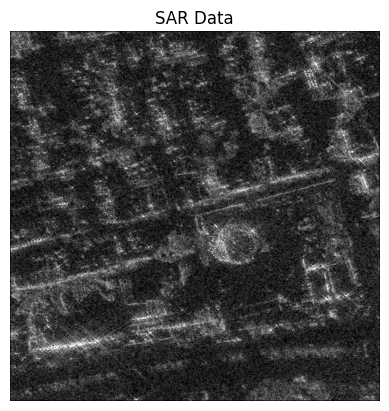

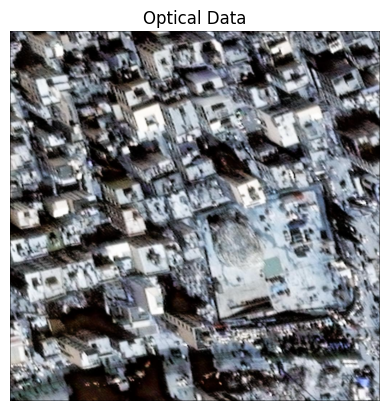

In [4]:
import cv2


sar_data = cv2.imread("/home/savvas/SUPER-NAS/USERS/Chirag/PROJECTS/202504-spacenet9/data/spacenet9-void/data/train/keypoint-crps/train-patch-1024/03_tiepoint_train_01_index_1_sar.tif", cv2.IMREAD_UNCHANGED)
opt_data = cv2.imread("/home/savvas/SUPER-NAS/USERS/Chirag/PROJECTS/202504-spacenet9/data/spacenet9-void/data/train/keypoint-crps/train-patch-1024/03_tiepoint_train_01_index_1_optical.tif", cv2.IMREAD_UNCHANGED)
import matplotlib.pyplot as plt
plt.imshow(sar_data, cmap='gray')
plt.title("SAR Data")
plt.axis('off')
plt.show()
plt.imshow(opt_data, cmap='gray')
plt.title("Optical Data")
plt.axis('off')
plt.show()

In [8]:
import rasterio as rio
from rasterio.enums import Resampling
from rasterio.transform import Affine

def resize_image_to_target(ds, width, height, resampling=Resampling.bilinear):
    data = ds.read(
        out_shape=(ds.count, height, width),
        resampling=resampling
    )
    return data

def save_resized_geotiff(output_path, data, reference_ds, width, height):
    meta = reference_ds.meta.copy()
    meta.update({
        'height': height,
        'width': width,
        'transform': reference_ds.transform,
        'count': data.shape[0],
        'dtype': data.dtype
    })
    with rio.open(output_path, 'w', **meta) as dst:
        dst.write(data)

def process_pair(sar_path, optical_path, sar_out_path, optical_out_path, size=(1024, 1024)):
    width, height = size

    with rio.open(optical_path) as optical_ds, rio.open(sar_path) as sar_ds:
        resized_optical = resize_image_to_target(optical_ds, width, height, Resampling.bilinear)
        resized_sar = resize_image_to_target(sar_ds, width, height, Resampling.bilinear)

        # Save both using optical georeference
        save_resized_geotiff(optical_out_path, resized_optical, optical_ds, width, height)
        save_resized_geotiff(sar_out_path, resized_sar, optical_ds, width, height)


# Example usage
sar_path = '/home/savvas/SUPER-NAS/USERS/Chirag/PROJECTS/202504-spacenet9/data/spacenet9-void/data/train/keypoint-crps/train-patch/02_tiepoint_train_01_index_0_optical.tif'
optical_path = '/home/savvas/SUPER-NAS/USERS/Chirag/PROJECTS/202504-spacenet9/data/spacenet9-void/data/train/keypoint-crps/train-patch/02_tiepoint_train_01_index_0_sar.tif'
sar_out_path = 'sar_resized.tif'
optical_out_path = 'optical_resized.tif'

process_pair(sar_path, optical_path, sar_out_path, optical_out_path)
